In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
from scipy.interpolate import UnivariateSpline

# Prepare macroeconomic data

In [2]:
factors = pd.ExcelFile('factors_data.xlsx')
usd_df = factors.parse('USD')

In [3]:
usd_data = pd.DataFrame({
    'Date_inflation_swap': pd.to_datetime(usd_df['Date_inflation_swap'], errors='coerce'),
    '5y5y_inflation_swap': pd.to_numeric(usd_df['5y5y inflation swap'], errors='coerce'),
    'Date_balance_sheet': pd.to_datetime(usd_df['Date_balance_sheet'], errors='coerce'),
    'balance_sheet': pd.to_numeric(usd_df['Balance sheet'], errors='coerce'),
    'Date_swap_spread': pd.to_datetime(usd_df['Date_swap_spread'], errors='coerce'),
    '10y_swap_spread': pd.to_numeric(usd_df['10y Swap Spread'], errors='coerce'),
    'Date_3m3m_1y3m': pd.to_datetime(usd_df['Date_3m3m_1y3m'], errors='coerce'),
    '3m3m_1y3m_curve_slope': pd.to_numeric(usd_df['3m3m-1y3m'], errors='coerce')
})
usd_data.head(15)

,Date_inflation_swap,5y5y_inflation_swap,Date_balance_sheet,balance_sheet,Date_swap_spread,10y_swap_spread,Date_3m3m_1y3m,3m3m_1y3m_curve_slope
0,2004-07-21,3.01,2000-01-05,640599.0,2000-06-22,-125.746,2000-06-22,0.205
1,2004-07-22,2.98,2000-01-12,611391.0,2000-06-23,-121.755,2000-06-23,0.219
2,2004-07-23,3.04,2000-01-19,599084.0,2000-06-26,-121.727,2000-06-26,0.180
3,2004-07-26,3.07,2000-01-26,595788.0,2000-06-27,-122.508,2000-06-27,0.172
4,2004-07-27,3.07,2000-02-02,581532.0,2000-06-28,-123.675,2000-06-28,0.179
5,2004-07-28,3.09,2000-02-09,589175.0,2000-06-29,-124.098,2000-06-29,0.146
6,2004-07-29,3.13,2000-02-16,583094.0,2000-06-30,-123.365,2000-06-30,0.171
7,2004-07-30,3.11,2000-02-23,589385.0,2000-07-03,-122.487,2000-07-03,0.112
8,2004-08-02,3.05,2000-03-01,585255.0,2000-07-04,NaN,2000-07-04,0.112
9,2004-08-03,3.02,2000-03-08,585191.0,2000-07-05,-118.323,2000-07-05,0.115


In [4]:
# Define the daily date range
start_date = pd.to_datetime('2004-07-21')
end_date = pd.to_datetime(usd_df[['Date_inflation_swap', 'Date_balance_sheet', 'Date_swap_spread', 'Date_3m3m_1y3m']].max().max())
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

def spline_interpolate(dates, values, full_range):
    mask = (~pd.isna(dates)) & (~pd.isna(values))
    dates = pd.to_datetime(dates[mask])
    values = values[mask]
    if len(dates) < 4:
        return pd.Series(np.interp(full_range.astype(np.int64), dates.astype(np.int64), values), index=full_range)
    x = (dates - dates.min()).dt.days.values
    y = values.values
    spline = UnivariateSpline(x, y, s=0)
    x_full = (full_range - dates.min()).days
    return pd.Series(spline(x_full), index=full_range)
# Interpolate each macro variable
inflation_interp = spline_interpolate(
    usd_df['Date_inflation_swap'], usd_df['5y5y inflation swap'], date_range
)
balance_interp = spline_interpolate(
    usd_df['Date_balance_sheet'], usd_df['Balance sheet'], date_range
)
swap_spread_interp = spline_interpolate(
    usd_df['Date_swap_spread'], usd_df['10y Swap Spread'], date_range
)
curve_slope_interp = spline_interpolate(
    usd_df['Date_3m3m_1y3m'], usd_df['3m3m-1y3m'], date_range
)

# Build the interpolated macro DataFrame
macro_interp_df = pd.DataFrame({
    'date': date_range,
    '5y5y_inflation_swap': inflation_interp.values,
    'balance_sheet': balance_interp.values,
    '10y_swap_spread': swap_spread_interp.values,
    '3m3m_1y3m_curve_slope': curve_slope_interp.values
})
# Round balance sheet to five decimal places
macro_interp_df['balance_sheet'] = macro_interp_df['balance_sheet'].round(5)
pd.set_option('display.float_format', '{:.5f}'.format)

macro_interp_df.head(50)


,date,5y5y_inflation_swap,balance_sheet,10y_swap_spread,3m3m_1y3m_curve_slope
0,2004-07-21,3.01000,777591.00000,-46.06200,1.13000
1,2004-07-22,2.98000,777420.37217,-46.19600,1.17100
2,2004-07-23,3.04000,777089.06557,-46.15900,1.15700
3,2004-07-24,3.07460,776641.04160,-46.06691,1.16165
4,2004-07-25,3.07757,776120.26166,-46.23040,1.18568
5,2004-07-26,3.07000,775570.68714,-46.95200,1.19800
6,2004-07-27,3.07000,775036.27946,-47.93200,1.17600
7,2004-07-28,3.09000,774561.00000,-47.33500,1.15100
8,2004-07-29,3.13000,774177.80320,-46.27000,1.17000
9,2004-07-30,3.11000,773875.61559,-46.24900,1.10600


In [97]:
# Show the first 50 rows starting from 2014-01-02
macro_interp_df[macro_interp_df['date'] >= '2014-01-02'].tail(10)

,date,5y5y_inflation_swap,balance_sheet,10y_swap_spread,3m3m_1y3m_curve_slope
7630,2025-06-11,15.04359,6878753.99840,23.70000,-0.65300
7631,2025-06-12,18.05171,6913888.10893,23.73600,-0.67000
7632,2025-06-13,21.50237,6952563.08824,25.51000,-0.62900
7633,2025-06-14,25.42584,6994931.47860,26.44184,-0.61100
7634,2025-06-15,29.85238,7041145.82228,26.19135,-0.62375
7635,2025-06-16,34.81229,7091358.66156,25.28700,-0.64700
7636,2025-06-17,40.33582,7145722.53871,24.57500,-0.66200
7637,2025-06-18,46.45326,7204389.99601,25.43800,-0.66100
7638,2025-06-19,53.19487,7267513.57572,26.63791,-0.65845
7639,2025-06-20,60.59094,7335245.82012,26.20200,-0.67400


In [5]:
macro_interp_df.tail(30)
# Remove the last two rows
macro_interp_df = macro_interp_df[:-10]

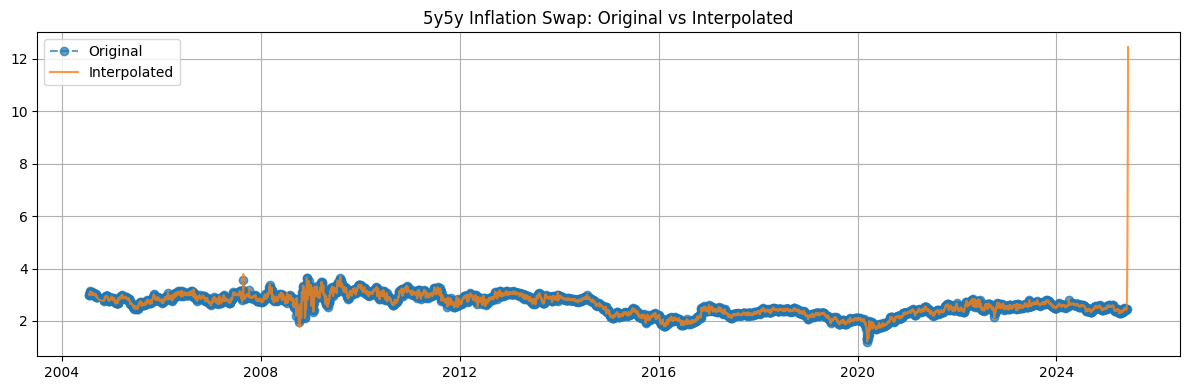

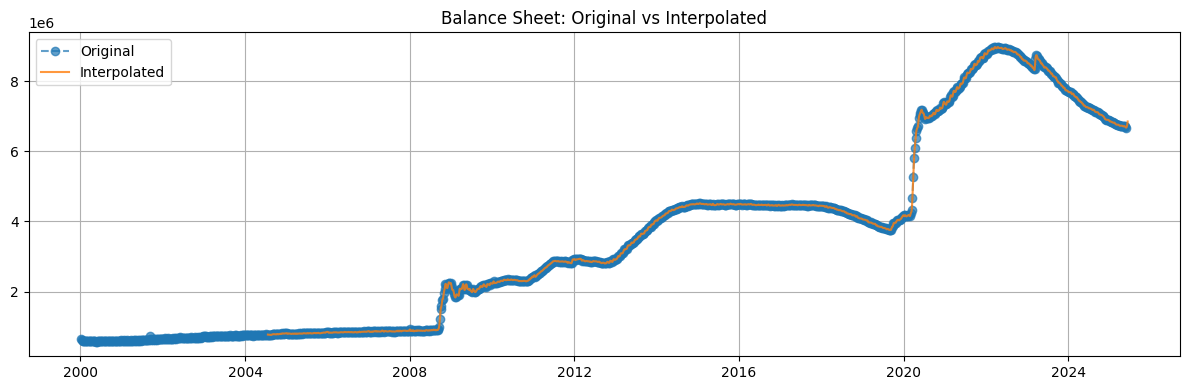

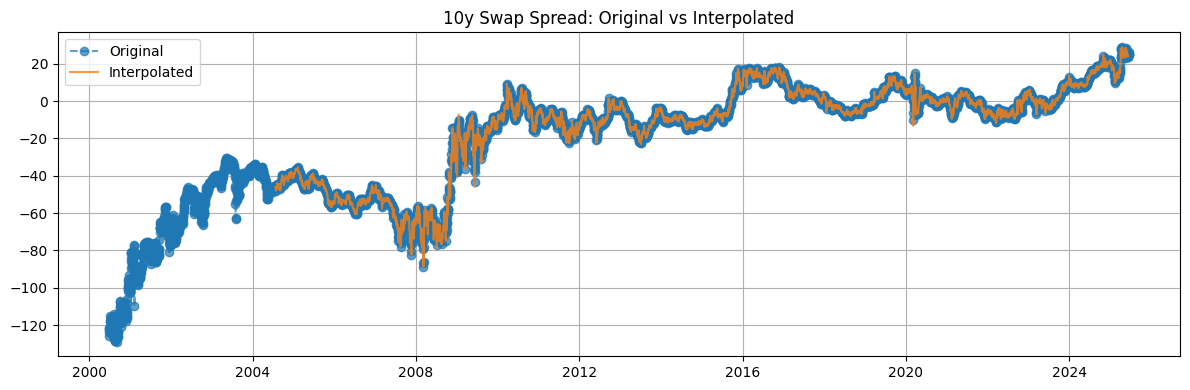

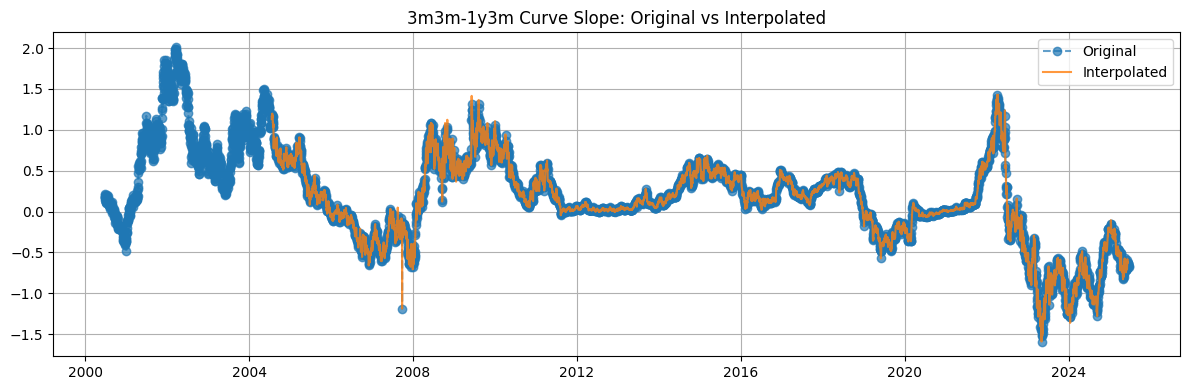

In [6]:
# 1. 5y5y Inflation Swap
plt.figure(figsize=(12, 4))
plt.plot(pd.to_datetime(usd_df['Date_inflation_swap']), usd_df['5y5y inflation swap'], 'o--', label='Original', alpha=0.7)
plt.plot(macro_interp_df['date'], macro_interp_df['5y5y_inflation_swap'], label='Interpolated', alpha=0.8)
plt.title('5y5y Inflation Swap: Original vs Interpolated')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Balance Sheet
plt.figure(figsize=(12, 4))
plt.plot(pd.to_datetime(usd_df['Date_balance_sheet']), usd_df['Balance sheet'], 'o--', label='Original', alpha=0.7)
plt.plot(macro_interp_df['date'], macro_interp_df['balance_sheet'], label='Interpolated', alpha=0.8)
plt.title('Balance Sheet: Original vs Interpolated')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. 10y Swap Spread
plt.figure(figsize=(12, 4))
plt.plot(pd.to_datetime(usd_df['Date_swap_spread']), usd_df['10y Swap Spread'], 'o--', label='Original', alpha=0.7)
plt.plot(macro_interp_df['date'], macro_interp_df['10y_swap_spread'], label='Interpolated', alpha=0.8)
plt.title('10y Swap Spread: Original vs Interpolated')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. 3m3m-1y3m Curve Slope
plt.figure(figsize=(12, 4))
plt.plot(pd.to_datetime(usd_df['Date_3m3m_1y3m']), usd_df['3m3m-1y3m'], 'o--', label='Original', alpha=0.7)
plt.plot(macro_interp_df['date'], macro_interp_df['3m3m_1y3m_curve_slope'], label='Interpolated', alpha=0.8)
plt.title('3m3m-1y3m Curve Slope: Original vs Interpolated')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

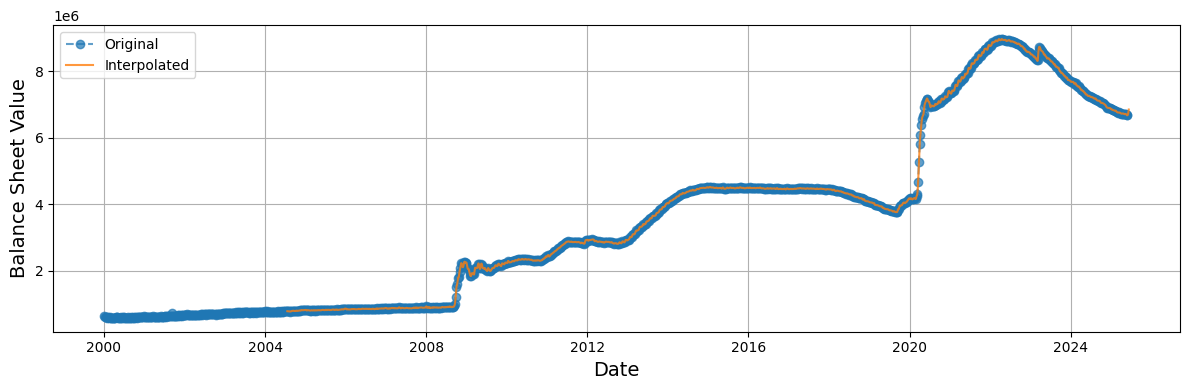

In [8]:
# 2. Balance Sheet
plt.figure(figsize=(12, 4))
plt.plot(pd.to_datetime(usd_df['Date_balance_sheet']), usd_df['Balance sheet'], 'o--', label='Original', alpha=0.7)
plt.plot(macro_interp_df['date'], macro_interp_df['balance_sheet'], label='Interpolated', alpha=0.8)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Balance Sheet Value', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Prepare rates and volatility data

In [100]:
# Clean swaps data
swaps = pd.read_csv('swap_data.csv')

# Convert years and months to months
def convert_to_months(s):
    if isinstance(s, str):
        s = s.strip().lower()
        if s.endswith('y'):
            return int(s[:-1]) * 12
        elif s.endswith('m'):
            return int(s[:-1])
    return np.nan

swaps['date'] = pd.to_datetime(swaps['date'])
swaps.dropna(subset=['date', 'tenor', 'value'], inplace=True)
swaps['value'] = pd.to_numeric(swaps['value'], errors='coerce')
swaps['start_months'] = swaps['start'].apply(convert_to_months)
swaps['tenor_years'] = swaps['tenor'].str.replace('y', '', regex=False).astype(int)
swaps['tenor_months'] = swaps['tenor'].apply(convert_to_months)

swaps.head()

,date,currency,start,tenor,value,start_months,tenor_years,tenor_months
0,2014-01-02,USD,3m,30y,3.94216,3,30,360
1,2014-01-02,USD,6m,30y,3.99302,6,30,360
2,2014-01-02,USD,3m,3y,1.04138,3,3,36
3,2014-01-02,USD,3m,2y,0.60833,3,2,24
4,2014-01-02,USD,3m,1y,0.36272,3,1,12


In [101]:
yield_vol = pd.read_csv('swaptions_yield_data.csv') # extract ATM percent yield volatilities and corresponding forward swap rates y

# Clean yield volatility data
def convert_to_months(val):
    if val.endswith('Y'):
        return int(val[:-1]) * 12
    elif val.endswith('M'):
        return int(val[:-1])
    else:
        return np.nan
    
yield_vol['date'] = pd.to_datetime(yield_vol['date'])
yield_vol.dropna(subset=['value'], inplace=True)
yield_vol['value'] = pd.to_numeric(yield_vol['value'], errors='coerce')
yield_vol[['currency', 'start_raw', 'tenor_raw']] = yield_vol['label'].str.extract(r'(\w+)_([0-9]+[MY])_([0-9]+Y)')
yield_vol['start_months'] = yield_vol['start_raw'].apply(convert_to_months)
yield_vol['tenor_years'] = yield_vol['tenor_raw'].str.replace('Y', '', regex=False).astype(int)
yield_vol['tenor_months'] = yield_vol['tenor_raw'].apply(convert_to_months)

yield_vol.head()

,date,label,value,currency,start_raw,tenor_raw,start_months,tenor_years,tenor_months
1,2014-01-02,USD_3M_05Y,40.39792,USD,3M,05Y,3,5,60
2,2014-01-03,USD_3M_05Y,39.77956,USD,3M,05Y,3,5,60
3,2014-01-06,USD_3M_05Y,39.96598,USD,3M,05Y,3,5,60
4,2014-01-07,USD_3M_05Y,39.95969,USD,3M,05Y,3,5,60
5,2014-01-08,USD_3M_05Y,40.17965,USD,3M,05Y,3,5,60


In [102]:
swaptions = pd.read_csv('swaptions_data.csv')
# Clean swaptions data

# Convert years and months to months
def convert_to_months(val):
    if val.endswith('Y'):
        return int(val[:-1]) * 12
    elif val.endswith('M'):
        return int(val[:-1])
    else:
        return np.nan
    
swaptions['date'] = pd.to_datetime(swaptions['date'])
swaptions.dropna(subset=['value'], inplace=True)
swaptions['value'] = pd.to_numeric(swaptions['value'], errors='coerce')
swaptions[['currency', 'start_raw', 'tenor_raw']] = swaptions['label'].str.extract(r'(\w+)_([0-9]+[MY])_([0-9]+Y)')
swaptions['start_months'] = swaptions['start_raw'].apply(convert_to_months)
swaptions['tenor_years'] = swaptions['tenor_raw'].str.replace('Y', '', regex=False).astype(int)
swaptions['tenor_months'] = swaptions['tenor_raw'].apply(convert_to_months)

swaptions.head()    

,date,label,value,currency,start_raw,tenor_raw,start_months,tenor_years,tenor_months
1,2014-01-02,EUR_3M_10Y,61.74100,EUR,3M,10Y,3,10,120
2,2014-01-03,EUR_3M_10Y,60.79753,EUR,3M,10Y,3,10,120
3,2014-01-06,EUR_3M_10Y,61.05012,EUR,3M,10Y,3,10,120
4,2014-01-07,EUR_3M_10Y,60.80262,EUR,3M,10Y,3,10,120
5,2014-01-08,EUR_3M_10Y,60.44799,EUR,3M,10Y,3,10,120


In [103]:
# Merge swaps and yield volatility data

# Merge swaps and swaptions on date, start, tenor, and currency
# Merge swaps and swaptions on date, start, tenor, and currency
swaps = swaps[['date', 'start_months', 'tenor_months', 'currency', 'value']]
swaptions = swaptions[['date', 'start_months', 'tenor_months', 'currency', 'value']]
yield_vol = yield_vol[['date', 'start_months', 'tenor_months', 'currency', 'value']]

# Merge the datasets swaptions and yield_vol
merged_1 = pd.merge(
    swaps,
    swaptions,
    on=['date', 'start_months', 'tenor_months', 'currency'],
    how='inner',
    suffixes=('_rate', '_bp_vol')
)
merged_swaps_vol = pd.merge(
    merged_1,
    yield_vol,
    on=['date', 'start_months', 'tenor_months', 'currency'],
    how='inner'
)
merged_swaps_vol = merged_swaps_vol.sort_values(['date', 'start_months', 'tenor_months'])

merged_swaps_vol.head()


,date,start_months,tenor_months,currency,value_rate,value_bp_vol,value
4,2014-01-02,3,12,USD,0.36272,23.48262,65.40401
107171,2014-01-02,3,12,EUR,0.45872,30.46005,69.00678
193361,2014-01-02,3,12,GBP,0.80009,32.62143,40.83753
3,2014-01-02,3,24,USD,0.60833,39.15793,64.77096
107170,2014-01-02,3,24,EUR,0.61332,37.94298,62.95276


In [104]:
usd_vol_data = merged_swaps_vol[merged_swaps_vol['currency'] == 'USD']

usd_vol_data = usd_vol_data.rename(columns={'value': 'value_yield_vol'})

usd_vol_data.head()

,date,start_months,tenor_months,currency,value_rate,value_bp_vol,value_yield_vol
4,2014-01-02,3,12,USD,0.36272,23.48262,65.40401
3,2014-01-02,3,24,USD,0.60833,39.15793,64.77096
2,2014-01-02,3,36,USD,1.04138,58.84324,56.96842
7,2014-01-02,3,60,USD,1.95127,78.36547,40.39792
17,2014-01-02,3,84,USD,2.59960,81.46671,31.41388


# Volatility backbone

In [105]:
# Fit the functional form
def yield_vol_model(y, a, b, c):
    return a * np.exp(-b * y) + c

In [106]:
# USD

# Fit the model to the data USD
y = usd_vol_data['value_rate'].values
yvol = usd_vol_data['value_yield_vol'].values

params_usd, _ = curve_fit(yield_vol_model, y, yvol, p0=(100, 2, 20)) # percent annualized yield vol vs rate relationship
a_usd, b_usd, c_usd = params_usd
print(f"Fitted parameters:\na = {a_usd:.4f}, b = {b_usd:.4f}, c = {c_usd:.4f}")

# Extract parameter uncertainties, the covariance matrix gives standard errors
perr = np.sqrt(np.diag(_))
print("a = %.4f ± %.4f" % (params_usd[0], perr[0]))
print("b = %.4f ± %.4f" % (params_usd[1], perr[1]))
print("c = %.4f ± %.4f" % (params_usd[2], perr[2]))

# Convert fitted yield vols to bp vols: bpvol = yieldvol * y/sqrt(251)
usd_vol_data['fitted_yield_vol'] = yield_vol_model(y,a_usd,b_usd,c_usd) * y / np.sqrt(251) #translate to a daily normal bpvol-vs-rate backbone

# Annualise the volatility values
usd_vol_data['value_bp_vol_daily'] = usd_vol_data['value_bp_vol'] / np.sqrt(251)  # Convert annualised bpvol to daily bpvol

# Residuals USD
usd_vol_data['residuals'] = usd_vol_data['value_bp_vol_daily'] - usd_vol_data['fitted_yield_vol'] # residual = (actual daily bp vol) – (backbone daily bp vol).

Fitted parameters:
a = 111.4936, b = 1.0453, c = 24.4603
a = 111.4936 ± 0.2483
b = 1.0453 ± 0.0039
c = 24.4603 ± 0.0781


In [107]:
# Reset index
usd_vol_data = usd_vol_data.reset_index(drop=True)
# Show the first 10 rows            
usd_vol_data.head(10)

,date,start_months,tenor_months,currency,value_rate,value_bp_vol,value_yield_vol,fitted_yield_vol,value_bp_vol_daily,residuals
0,2014-01-02,3,12,USD,0.36272,23.48262,65.40401,2.30711,1.48221,-0.82490
1,2014-01-02,3,24,USD,0.60833,39.15793,64.77096,3.20585,2.47163,-0.73422
2,2014-01-02,3,36,USD,1.04138,58.84324,56.96842,4.07529,3.71415,-0.36114
3,2014-01-02,3,60,USD,1.95127,78.36547,40.39792,4.79864,4.94638,0.14775
4,2014-01-02,3,84,USD,2.59960,81.46671,31.41388,5.22180,5.14213,-0.07967
5,2014-01-02,3,120,USD,3.17091,79.35128,25.06768,5.70671,5.00861,-0.69810
6,2014-01-02,3,360,USD,3.94216,69.05020,17.52754,6.53666,4.35841,-2.17825
7,2014-01-02,6,12,USD,0.43319,31.78700,74.38812,2.60715,2.00638,-0.60078
8,2014-01-02,6,24,USD,0.75788,49.43100,65.60401,3.58528,3.12006,-0.46522
9,2014-01-02,6,36,USD,1.23454,67.75800,55.11222,4.29637,4.27685,-0.01952


# Merge macro and swaption data

In [108]:
# Merge macro and swaption data on swaption date (many swaptions per date)
usd_vol_data = usd_vol_data.copy()
macro_interp_df = macro_interp_df.copy()

# Merge: for each swaption row, attach the macro factors for that date
usd_vol_macro = usd_vol_data.merge(
    macro_interp_df,
    left_on='date',
    right_on='date',
    how='left'
)
# Show result
usd_vol_macro.head(55)

,date,start_months,tenor_months,currency,value_rate,value_bp_vol,value_yield_vol,fitted_yield_vol,value_bp_vol_daily,residuals,5y5y_inflation_swap,balance_sheet,10y_swap_spread,3m3m_1y3m_curve_slope
0,2014-01-02,3,12,USD,0.36272,23.48262,65.40401,2.30711,1.48221,-0.82490,2.94700,4022000.51995,-4.71800,0.12300
1,2014-01-02,3,24,USD,0.60833,39.15793,64.77096,3.20585,2.47163,-0.73422,2.94700,4022000.51995,-4.71800,0.12300
2,2014-01-02,3,36,USD,1.04138,58.84324,56.96842,4.07529,3.71415,-0.36114,2.94700,4022000.51995,-4.71800,0.12300
3,2014-01-02,3,60,USD,1.95127,78.36547,40.39792,4.79864,4.94638,0.14775,2.94700,4022000.51995,-4.71800,0.12300
4,2014-01-02,3,84,USD,2.59960,81.46671,31.41388,5.22180,5.14213,-0.07967,2.94700,4022000.51995,-4.71800,0.12300
5,2014-01-02,3,120,USD,3.17091,79.35128,25.06768,5.70671,5.00861,-0.69810,2.94700,4022000.51995,-4.71800,0.12300
6,2014-01-02,3,360,USD,3.94216,69.05020,17.52754,6.53666,4.35841,-2.17825,2.94700,4022000.51995,-4.71800,0.12300
7,2014-01-02,6,12,USD,0.43319,31.78700,74.38812,2.60715,2.00638,-0.60078,2.94700,4022000.51995,-4.71800,0.12300
8,2014-01-02,6,24,USD,0.75788,49.43100,65.60401,3.58528,3.12006,-0.46522,2.94700,4022000.51995,-4.71800,0.12300
9,2014-01-02,6,36,USD,1.23454,67.75800,55.11222,4.29637,4.27685,-0.01952,2.94700,4022000.51995,-4.71800,0.12300


In [109]:
usd_vol_macro.tail(55)

,date,start_months,tenor_months,currency,value_rate,value_bp_vol,value_yield_vol,fitted_yield_vol,value_bp_vol_daily,residuals,5y5y_inflation_swap,balance_sheet,10y_swap_spread,3m3m_1y3m_curve_slope
107112,2024-06-06,36,24,USD,3.89484,110.96121,28.79934,6.48076,7.00381,0.52305,2.58900,7254432.36395,9.28600,-0.83800
107113,2024-06-06,36,36,USD,3.90886,108.44132,28.03033,6.49726,6.84476,0.34749,2.58900,7254432.36395,9.28600,-0.83800
107114,2024-06-06,36,60,USD,3.94185,103.65972,26.54426,6.53629,6.54294,0.00665,2.58900,7254432.36395,9.28600,-0.83800
107115,2024-06-06,36,84,USD,3.97687,100.48246,25.48708,6.57803,6.34240,-0.23564,2.58900,7254432.36395,9.28600,-0.83800
107116,2024-06-06,36,120,USD,4.02714,96.14979,24.05903,6.63847,6.06892,-0.56955,2.58900,7254432.36395,9.28600,-0.83800
107117,2024-06-06,36,360,USD,3.80072,86.80445,23.11153,6.37131,5.47905,-0.89226,2.58900,7254432.36395,9.28600,-0.83800
107118,2024-06-06,60,12,USD,3.93857,106.41922,27.46393,6.53240,6.71712,0.18472,2.58900,7254432.36395,9.28600,-0.83800
107119,2024-06-06,60,24,USD,3.95443,103.23568,26.50662,6.55125,6.51618,-0.03508,2.58900,7254432.36395,9.28600,-0.83800
107120,2024-06-06,60,36,USD,3.97622,101.39408,25.87324,6.57726,6.39994,-0.17732,2.58900,7254432.36395,9.28600,-0.83800
107121,2024-06-06,60,60,USD,4.01409,97.90757,24.71767,6.62273,6.17987,-0.44286,2.58900,7254432.36395,9.28600,-0.83800


In [110]:
# Save data in CSV file
usd_vol_macro.to_csv('usd_regression_dataW8.csv', index=False)